In [1]:
import numpy as np
import os
import os.path

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import sep

from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline

In [37]:
num = '840'
path = 'hsc_images/'+num+'/'

img_data = fits.open(path+'redadd_'+num+'_HSC-I_full_img.fits')[0].data[400:800,400:800]
sig_data = fits.open(path+'redadd_'+num+'_HSC-I_full_sig.fits')[0].data[400:800,400:800]
msk_data = fits.open(path+'redadd_'+num+'_HSC-I_full_bad.fits')[0].data[400:800,400:800]

In [38]:
# Change the byteorder
img_data = img_data.byteswap().newbyteorder()
sig_data = sig_data.byteswap().newbyteorder()
msk_data = msk_data.byteswap().newbyteorder()

In [39]:
#get background model
bkg_model = sep.Background(img_data, mask=msk_data, bw=32, bh=32, fw=3, fh=3)

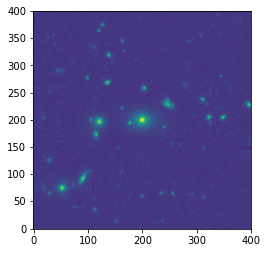

In [40]:
img_sub = img_data - bkg_model.back()
plt.imshow(np.arcsinh(img_sub),interpolation='none', origin='lower')

In [41]:
print(np.max(sig_data))
print(np.min(sig_data))

0.173377170036
0.0543730457067
